In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from scipy.ndimage.interpolation import shift
import heapq

In [2]:
# insert the location of the file here
img = cv2.imread("images/17.png",1)

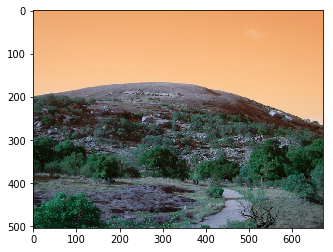

In [3]:
plt.imshow(img)

In [4]:
img.shape

(504, 672, 3)

In [5]:
#dividing into blocks of 28*28
rows = len(img)
cols = len(img[0])

#specify the block sizes below
blk_sz_x = 28
blk_sz_y = 28

num_blk_x = rows//blk_sz_x
num_blk_y = cols//blk_sz_y
num_blk = num_blk_x*num_blk_y

In [6]:
CROSSOVER_PR = 0.3
MUTATION_PR = 0.01
ELITE_PT=0.5

In [7]:
#helper functions

#block stores all the puzzle blocks
def divide_image(img,num_blk_x,num_blk_y,blk_sz_x,blk_sz_y):
    blocks = []

    for i in range(num_blk_x):
        for j in range(num_blk_y):
            blocks.append(img[i*blk_sz_x:(i+1)*blk_sz_x, j*blk_sz_y:(j+1)*blk_sz_y])

    return blocks

#initializing a random population
def init_population(ppl_sz,num_blk_x,num_blk_y,num_blk):

    population = []

    for i in range(ppl_sz):
        population.append(np.random.permutation(num_blk).reshape(num_blk_x,num_blk_y))
        
    return population

#returns the image from the chromosome data
def get_image(chromosome,blocks):
    img_chromosome_row = []
    for i in range(num_blk_x):
        row = blocks[chromosome[i][0]]
        for j in range(1,num_blk_y):
            row = np.concatenate((row,blocks[chromosome[i][j]]),axis=1)
        img_chromosome_row.append(row)
        
    img_chromosome = img_chromosome_row[0]
    for i in range(1,num_blk_x):
        img_chromosome = np.concatenate((img_chromosome,img_chromosome_row[i]),axis=0)
    return img_chromosome

#displays the image
def visual_chromosome(chromosome, blocks):
    plt.imshow(get_image(chromosome,blocks))
      
#cost function (L2 distance)
def compute_cost(chromosome,blocks,num_blk_x,num_blk_y):
    cost = 0
    for i in range(num_blk_x-1):
        for j in range(num_blk_y-1):
            p = blocks[chromosome[i][j]]
            p1 = blocks[chromosome[i+1][j]]
            p2 = blocks[chromosome[i][j+1]]
            cost += compute_edge_cost(p,p1,'b')
            cost += compute_edge_cost(p,p2,'r')
    return cost
               
def isValid(i,j,num_blk_x,num_blk_y):
    return 0<=i<num_blk_x and 0<=j<num_blk_y
              
#finds and returns the dictionary of common partners in both the parents
def find_partner(m1,m2,num_blk_x,num_blk_y):
    dic = {}
    dic['l'] = {}
    dic['r'] = {}
    dic['t'] = {}
    dic['b'] = {}
    
    m2_loc = [-1]*num_blk_x*num_blk_y
    for i in range(num_blk_x):
        for j in range(num_blk_y):
            m2_loc[m2[i][j]] = (i,j)
    for i in range(num_blk_x):
        for j in range(num_blk_y):
            (x,y) = m2_loc[m1[i][j]]
            if isValid(i,j+1,num_blk_x,num_blk_y) and isValid(x,y+1,num_blk_x,num_blk_y):
                if m1[i,j+1] == m2[x,y+1]:
                    dic['r'][m1[i,j]] = m1[i,j+1]
                    dic['l'][m1[i,j+1]] = m1[i,j]

            if isValid(i+1,j,num_blk_x,num_blk_y) and isValid(x+1,y,num_blk_x,num_blk_y):
                if m1[i+1,j] == m2[x+1,y]:
                    dic['b'][m1[i,j]] = m1[i+1,j]
                    dic['t'][m1[i+1,j]] = m1[i,j]
    return dic

#returns the boundary region of a block
def bndry(i,j):
    return [('l',(i,j),(i,j-1)), ('r',(i,j),(i,j+1)), ('t',(i,j),(i-1,j)), ('b',(i,j),(i+1,j))]
               
#returns the complimentary direction of the direction passed as argument
def cmp(i):
    if i=='l':
        return 'r'
    if i=='r':
        return 'l'
    if i=='t':
        return 'b'
    if i=='b':
        return 't'
               
#returns bool value signifying whether a block region is inside boundary region or not
def is_in_range(stx,sty,enx,eny,position):
    return max(enx,position[0])-min(stx,position[0])+1<=num_blk_x and max(eny,position[1])-min(sty,position[1])+1<=num_blk_y 
               
#edge cost between two blocks in the provided direction
def compute_edge_cost(first_piece,second_piece,orient):
    rows, columns, _ = first_piece.shape
    
    color_difference = None
    if orient == 'r':
        color_difference = first_piece[:rows, columns - 1, :] - second_piece[:rows, 0, :]
    if orient == 'b':
        color_difference = first_piece[rows - 1, :columns, :] - second_piece[0, :columns, :]
    if orient == 'l':
        color_difference = second_piece[:rows, columns - 1, :] - first_piece[:rows, 0, :]
    if orient == 't':
        color_difference = second_piece[rows - 1, :columns, :] - first_piece[0, :columns, :]
    
    squared_color_difference = np.square(color_difference)
    total_difference = np.sum(squared_color_difference)
    
    value = np.sqrt(total_difference)

    return value

In [8]:
# preprocesses the image before the genetic algorithm starts. 
# it computes and saves the edge cost between every two blocks in all directions in increasing order.
# this helps to significantly improve the runtime by avoiding repetitive calculations in each iteration
def preprocess(blocks,num_blks):
    best_match = []
    s = "tblr"
    sc= "btrl"
    for i in range(num_blks):
        best_match.append({"t": [],"r": [],"b": [],"l": []})
    for i in range(num_blks-1):
        for j in range(i+1, num_blks):
            for k in range(len(s)):
                x = compute_edge_cost(blocks[i],blocks[j],s[k])
                best_match[i][s[k]].append((x,j))
                best_match[j][sc[k]].append((x,i))
    for i in range(num_blks):
        for j in s:
            best_match[i][j].sort(key=lambda x:x[0])
    return best_match

In [9]:
# the crossover function
def crossover(m1,m2,best_match,blocks,num_blk_x,num_blk_y):
    child = np.array([[-1]*(2*num_blk_y+1)]*(2*num_blk_x+1))
    num_blk = num_blk_x*num_blk_y

    partner = find_partner(m1,m2,num_blk_x,num_blk_y)

    blk_used = set([])
    
    first_ele = random.randint(0,num_blk-1)
    stx = enx = num_blk_x
    sty = eny = num_blk_y
        
    child[stx][sty] = first_ele
    blk_used.add(first_ele)
    heap = []
    boundary = bndry(num_blk_x,num_blk_y)
    for orientation,pos,position in boundary:
        if child[position]==-1 and is_in_range(stx,sty,enx,eny,position):
            if child[pos] in partner[orientation]:
                heapq.heappush(heap,(-10,partner[orientation][child[pos]],position))
            elif best_match[child[pos]][orientation][0][1] == best_match[best_match[child[pos]][orientation][0][1]][cmp(orientation)][0][1]:
                heapq.heappush(heap,(-1,best_match[child[pos]][orientation][0][1],position))
            else:
                for cst,val in best_match[child[pos]][orientation]:
                    if val not in blk_used:
                         heapq.heappush(heap,(cst,val,position))

    while len(heap)>0:
        _, piece,pos = heapq.heappop(heap)
        if piece in blk_used or not is_in_range(stx,sty,enx,eny,pos) or child[pos] != -1:
            continue
        child[pos] = piece
        blk_used.add(piece)

        stx = min(stx,pos[0])
        sty = min(sty,pos[1])
        enx = max(enx,pos[0])
        eny = max(eny,pos[1])
        boundary = bndry(pos[0],pos[1])
        for orientation,pos,position in boundary:
            if child[position]==-1 and is_in_range(stx,sty,enx,eny,position):
                if random.random()>MUTATION_PR:
                    bm = best_match[child[pos]][orientation][0][1]
                    if child[pos] in partner[orientation] and partner[orientation][child[pos]] not in blk_used:
                        heapq.heappush(heap,(-2,partner[orientation][child[pos]],position))
                    elif best_match[bm][cmp(orientation)][0][1] == child[pos] and bm not in blk_used:
                        heapq.heappush(heap,(-1,bm,position))
                    else:
                        for cst,val in best_match[child[pos]][orientation]:
                            if val not in blk_used:
                                 heapq.heappush(heap,(cst,val,position))
                else:
                    heapq.heappush(heap,(-1.5,random.randint(0,num_blk-1),position))
                
    child = child[stx:enx+1, sty:eny+1]
    if len(blk_used)!=num_blk:
        blk_aval = set(np.arange(0,num_blk)).difference(blk_used)
        for i in range(num_blk_x):
            for j in range(num_blk_y):
                if child[i,j] == -1:
                    child[i,j] = blk_aval.pop()
    return child

In [10]:
# returns the next generation chromosome
def next_gen(population,blocks,num_blk_x,num_blk_y,ppl_sz):
    cost = []
    for member in population:
        cost.append(compute_cost(member,blocks,num_blk_x,num_blk_y))
    zipped_list = zip(cost,population)
    sorted_zipped_list = sorted(zipped_list,key=lambda x: x[0])
    new_pop = [element for _, element in sorted_zipped_list]
    cost.sort()
    next_pop = [new_pop[0]]
    ind = 1
    while len(next_pop)<int(ELITE_PT*ppl_sz) and ind<len(new_pop):
        if cost[ind-1]!=cost[ind]:
            next_pop.append(new_pop[ind])
        ind+=1
    random.shuffle(new_pop)
    next_pop.extend(new_pop[:ppl_sz-len(next_pop)])
    return next_pop, np.average(cost)

In [11]:
total_gen = 25
curr_gen = 0
ppl_sz = 150

blocks = divide_image(img,num_blk_x,num_blk_y,blk_sz_x,blk_sz_y)

population = init_population(ppl_sz,num_blk_x,num_blk_y,num_blk)
best_chromosome_gen = []
avg_cost_gen = []

The best cost till in the first generation is: 70367.7289593


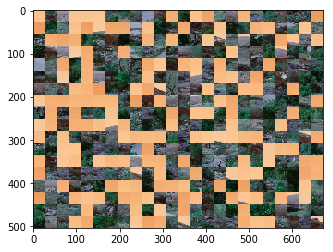

In [12]:
# prints the best chromosome in the initial population
cost = [compute_cost(i,blocks,num_blk_x,num_blk_y) for i in population]
bst = cost.index(min(cost))

print("The best cost till in the first generation is: " + str(cost[bst]))
visual_chromosome(population[bst],blocks)

In [13]:
# preprocessing the image
best_match = preprocess(blocks,num_blk)

In [14]:
# time to run our genetic algorithm. Yay!!!
for gen in range(curr_gen,total_gen):
    
    random.shuffle(population)
    new_population = population[:]

    for i in range(0,len(population),2):
        cross_pbt = random.random()
        if cross_pbt<CROSSOVER_PR:
            child = crossover(population[i],population[i+1],best_match,blocks,num_blk_x,num_blk_y)
            new_population.append(child)
    population, avg_cost = next_gen(new_population,blocks,num_blk_x,num_blk_y,ppl_sz)
    
    best_chromosome_gen.append(population[0])
    avg_cost_gen.append(avg_cost)
    
    print("Generation " + str(gen+1) + " completed. Best cost: "+str(compute_cost(best_chromosome_gen[-1],blocks,num_blk_x,num_blk_y)) + "   Avg cost: " + str(avg_cost))
    
    curr_gen += 1

Generation 1 completed. Best cost: 39860.3213673   Avg cost: 67822.6786245
Generation 2 completed. Best cost: 39860.3213673   Avg cost: 62046.591912
Generation 3 completed. Best cost: 39715.737374   Avg cost: 55363.5093378
Generation 4 completed. Best cost: 39715.737374   Avg cost: 49974.8830593
Generation 5 completed. Best cost: 39571.3225138   Avg cost: 45513.7368706
Generation 6 completed. Best cost: 39474.633301   Avg cost: 42944.1871448
Generation 7 completed. Best cost: 39474.633301   Avg cost: 40899.4808328
Generation 8 completed. Best cost: 39162.5028961   Avg cost: 40483.9606297
Generation 9 completed. Best cost: 39162.5028961   Avg cost: 40444.2254003
Generation 10 completed. Best cost: 39162.5028961   Avg cost: 40286.5633833
Generation 11 completed. Best cost: 39162.5028961   Avg cost: 40199.1090571
Generation 12 completed. Best cost: 39162.5028961   Avg cost: 40238.6613109
Generation 13 completed. Best cost: 39162.5028961   Avg cost: 40023.6122723
Generation 14 completed. B

The best cost achieved is: 38959.4420697
The cost of original image is: 38456.9162801


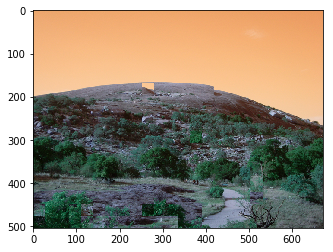

In [15]:
# displays the final result of the algorithm

ind = -1
visual_chromosome(population[ind],blocks)
print("The best cost achieved is: " + str(compute_cost(best_chromosome_gen[ind],blocks,num_blk_x,num_blk_y)))
print("The cost of original image is: " + str(compute_cost(np.arange(num_blk).reshape(num_blk_x,num_blk_y),blocks,num_blk_x,num_blk_y)))